<a href="https://colab.research.google.com/github/fanar-barboud/Data-structure/blob/main/Phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**[1] Problem**
The purpose of this project is to analyze and predict the productivity of garment factory employees using data mining techniques. The main goal is to classify whether employees can achieve their target productivity and to cluster employees based on similar productivity patterns. By applying classification and clustering techniques, we aim to analyze employees' data, predict their likelihood of meeting productivity targets, and understand different productivity patterns based on shared characteristics.


#**[2] Data Mining Task**

## Classification:



For classification, the model will be trained to predict whether an employee meets their targeted productivity using attributes such as working hours, experience, overtime, incentives, and other relevant factors. The goal is to identify employees who will likely meet their productivity targets based on their characteristics.

## Clustering:

For clustering, the model will group employees with similar productivity patterns. These clusters will be used to predict results for new employees based on the group they are most similar to, helping better manage employee performance.

#**[3] Data**

## Dataset Overview
Exploratory analysis in Phase 1 and Phase 2 focused on understanding the structure, distribution, and quality of the Garment Worker Productivity dataset. The dataset contains 1,197 observations and includes operational, temporal, and productivity-related attributes, with actual_productivity serving as the main variable of interest.
## Distribution and Summary Statistics

Phase 1 and 2 analysis showed that several numerical features—such as wip, over_time, idle_time, and smv—were skewed with noticeable extreme values. Histograms, boxplots, and five-number summaries confirmed that these variables had long right tails, indicating the need for normalization before clustering.

actual_productivity itself was concentrated mostly between 0.3 and 0.8, which helped guide later decisions for classification (discretizing it) and clustering (keeping it numeric).

## Relationships Between Variables

Scatter plots and correlation analysis highlighted several meaningful patterns:

- smv and wip showed a positive relationship.

- Higher idle_time was generally associated with lower productivity.

These observations supported the selection of relevant numeric features for clustering.

## Data Quality and Missing Values

Only the wip attribute contained missing values, which were imputed using the median to maintain the distribution without removing entries. No duplicate or invalid rows were detected, and minor formatting inconsistencies in categorical features were corrected.

## Summary

The EDA revealed important characteristics of the dataset, including skewed distributions, meaningful correlations, and overall good data quality. These findings guided the preprocessing choices and feature selection strategies used in Phase 3.

In [137]:
import pandas as pd

In [138]:
df=pd.read_csv('/content/Raw_data.csv')

In [139]:
print('Number of rows',df.shape[0])   #num of rows
print('Number of columns',df.shape[1]) #num of columns

Number of rows 1197
Number of columns 15


In [140]:
print(df.dtypes) #data types of attributes

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object


In [141]:
df['categorized_label'] = df['actual_productivity']
num_bins = 3

df['Label'] = pd.cut(df['actual_productivity'], bins=num_bins, labels=['Low   ','Medium', 'High  '])
print('----------------------\nnum -- Class Labels --\n----------------------')
print(df['Label'])
print('-------------------------------------------------------')

print('-------------------------------------------------------')
print('Number of instances for each label:') #print the count of instances(rows) for each label
print('-------------------------------------------------------')
print('Class  -- Count ---------------------------------------')
print(df['Label'].value_counts())
print('-------------------------------------------------------')

----------------------
num -- Class Labels --
----------------------
0       High  
1       High  
2       Medium
3       Medium
4       Medium
         ...  
1192    Medium
1193    Medium
1194    Medium
1195    Low   
1196    Low   
Name: Label, Length: 1197, dtype: category
Categories (3, object): ['Low   ' < 'Medium' < 'High  ']
-------------------------------------------------------
-------------------------------------------------------
Number of instances for each label:
-------------------------------------------------------
Class  -- Count ---------------------------------------
Label
Medium    691
High      344
Low       162
Name: count, dtype: int64
-------------------------------------------------------


In [142]:
df.head()  #sample of raw dataset

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,categorized_label,Label
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,0.940725,High
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,0.886500,High
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,0.800570,Medium
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,0.800570,Medium
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,0.800382,Medium


#**[4] Data Preprocessing**
## Preprocessing from Phase 2

The following preprocessing steps were completed in Phase 2:

- Data Cleaning:
Checked for inconsistencies, formatting issues, and invalid category values. Department names and related fields were standardized.

- Missing Values:
Only the wip feature had missing entries, which were imputed using the median to avoid losing data.

- Outlier & Distribution Analysis:
Numerical features (wip, over_time, idle_time, smv) showed skewness and extreme values. Outliers were not removed, as they represent real production conditions, but handled later through scaling.

- Initial Validation:
Verified numeric ranges and ensured no structural or duplicated data issues.


---


## Additional Preprocessing for Phase 3

### **For Classification**
- Encoded categorical attributes (e.g., department, team) using Label Encoding.

- Prepared the target variable for classification.

- Created multiple train/test splits (90/10, 80/20, 70/30) for comparison.

###**For Clustering**

- Selected only numeric operational features for K-Means:
smv, over_time, wip, incentive, idle_time.

- Applied StandardScaler to normalize all clustering features, ensuring equal contribution to distance calculations and improving cluster separation.

In [143]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math


df = pd.read_csv('/content/Raw_data.csv')
#df = pd.read_csv('Raw_data.csv')
df = pd.DataFrame(df)

# --- Make a copy of the raw dataset to keep it unedited ---
Preprocessed_dataset = df.copy()

In [144]:
# --- Have a look at the domains for our categorical columns ---
for col in ['department', 'day', 'quarter']:
    print(f"\nOriginal values in {col}:")
    print(df[col].unique())


Original values in department:
['sweing' 'finishing ' 'finishing']

Original values in day:
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']

Original values in quarter:
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']


In [145]:
# --- Correct department name typos ---
Preprocessed_dataset['department'] = Preprocessed_dataset['department'].replace({
    'sweing': 'sewing',
    'finishing ': 'finishing'
})

# --- Display unique cleaned values for our categorical columns ---
for col in ['department', 'day', 'quarter']:
    print(f"\nCleaned values in {col}:")
    print(Preprocessed_dataset[col].unique())


Cleaned values in department:
['sewing' 'finishing']

Cleaned values in day:
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']

Cleaned values in quarter:
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']


In [146]:
Preprocessed_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
team,1197.0,6.426901,3.463963,1.000000,3.000000,6.000000,9.000000,12.000000
targeted_productivity,1197.0,0.729632,0.097891,0.070000,0.700000,0.750000,0.800000,0.800000
smv,1197.0,15.062172,10.943219,2.900000,3.940000,15.260000,24.260000,54.560000
wip,691.0,1190.465991,1837.455001,7.000000,774.500000,1039.000000,1252.500000,23122.000000
over_time,1197.0,4567.460317,3348.823563,0.000000,1440.000000,3960.000000,6960.000000,25920.000000
incentive,1197.0,38.210526,160.182643,0.000000,0.000000,0.000000,50.000000,3600.000000
idle_time,1197.0,0.730159,12.709757,0.000000,0.000000,0.000000,0.000000,300.000000
idle_men,1197.0,0.369256,3.268987,0.000000,0.000000,0.000000,0.000000,45.000000
no_of_style_change,1197.0,0.150376,0.427848,0.000000,0.000000,0.000000,0.000000,2.000000
no_of_workers,1197.0,34.609858,22.197687,2.000000,9.000000,34.000000,57.000000,89.000000


In [147]:
outlier_summary = {}
#Selecting only numerical columns
numeric_cols = [
    'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
    'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

for col in numeric_cols:
    Q1 = Preprocessed_dataset[col].quantile(0.25)
    Q3 = Preprocessed_dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (Preprocessed_dataset[col] < lower) | (Preprocessed_dataset[col] > upper)
    outlier_count = mask.sum()
    outlier_summary[col] = {'Q1':Q1, 'Q3':Q3, 'IQR':IQR, 'lower':lower, 'upper':upper, 'count':int(outlier_count)}
    print(f"\n{col}: {outlier_count} outliers")


targeted_productivity: 79 outliers

smv: 0 outliers

wip: 22 outliers

over_time: 1 outliers

incentive: 11 outliers

idle_time: 18 outliers

idle_men: 18 outliers

no_of_style_change: 147 outliers

no_of_workers: 0 outliers

actual_productivity: 54 outliers


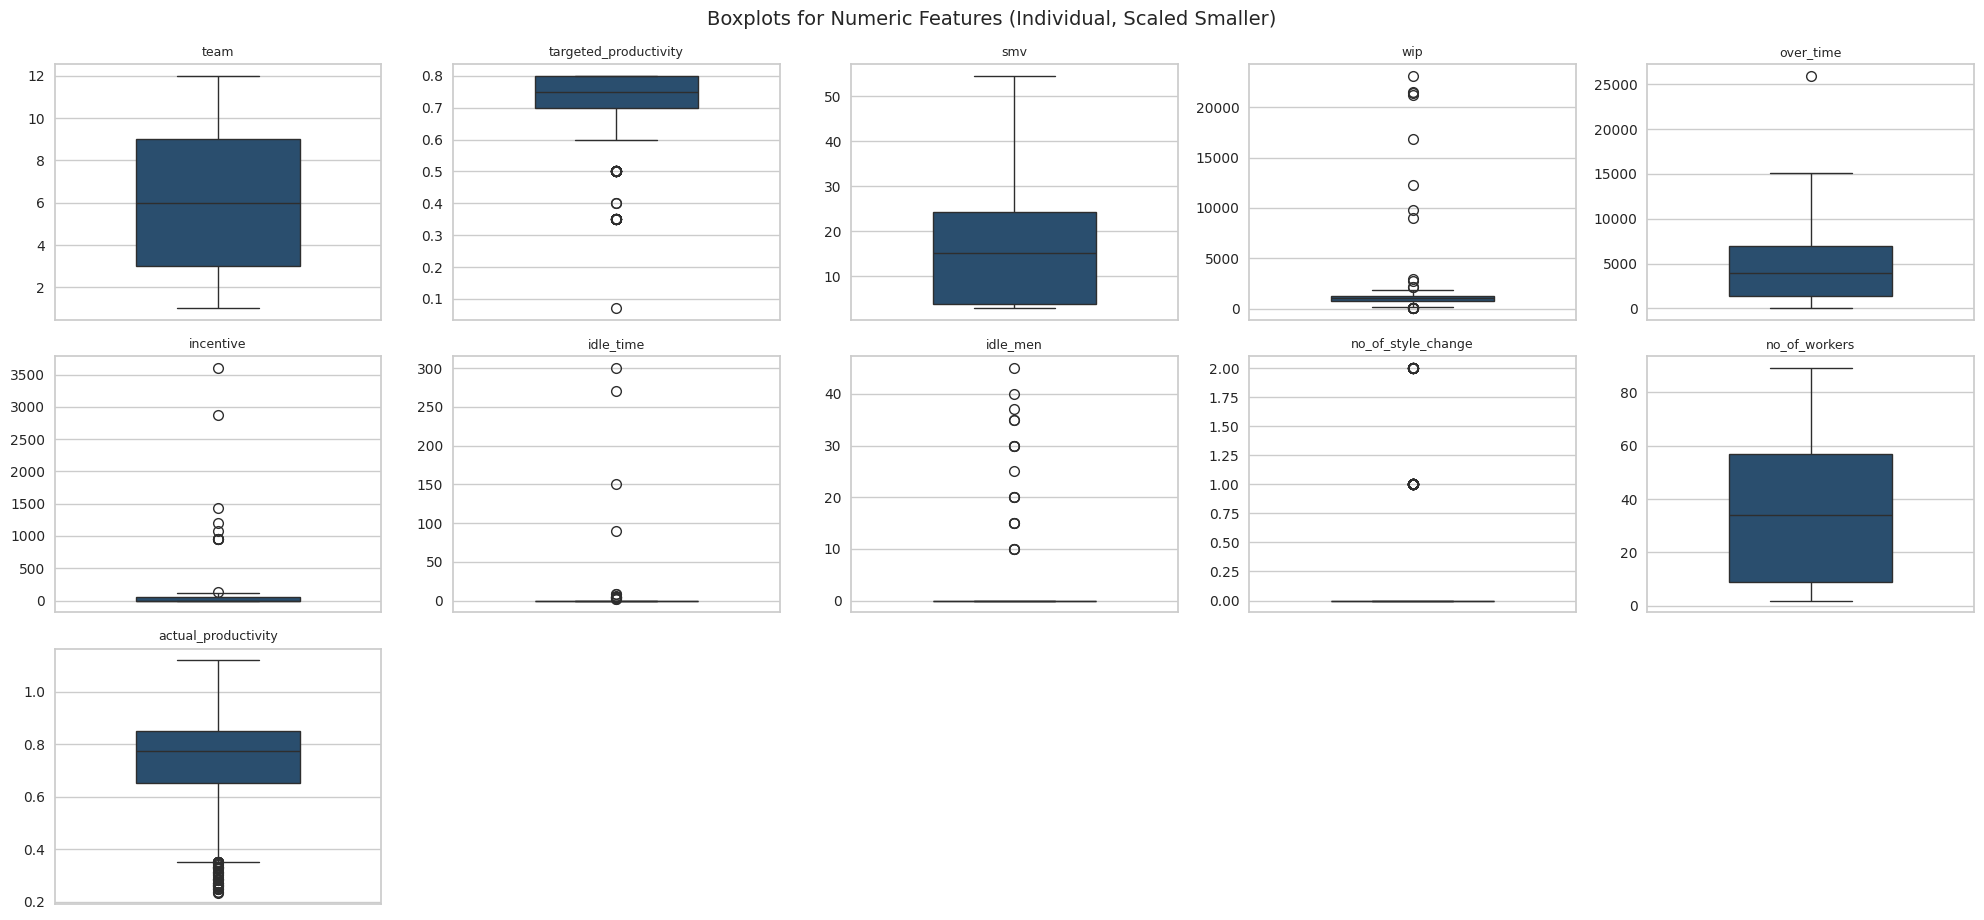

In [148]:
# Select numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Layout settings
cols_per_row = 5  # number of boxplots per row
rows = math.ceil(len(numeric_cols) / cols_per_row)

# Set up figure
plt.figure(figsize=(4 * cols_per_row, 3 * rows))
sns.set_style('whitegrid')

# Loop through each numeric feature
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.boxplot(y=df[col], color='#1f4e79', width=0.5)  # darker blue
    plt.title(col, fontsize=9)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

plt.suptitle('Boxplots for Numeric Features (Individual, Scaled Smaller)', fontsize=14, y=1.02)
plt.show()

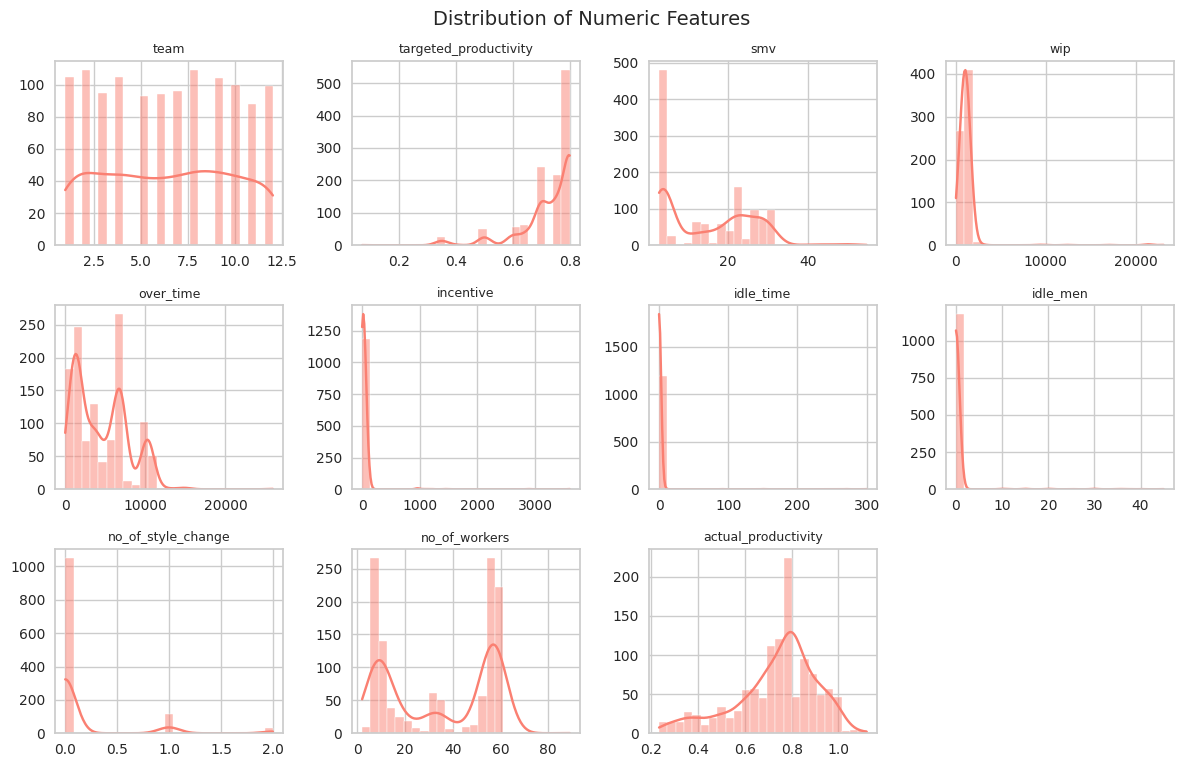

In [149]:
plots_per_row = 4        # how many histograms per row
rows = 3                 # total number of rows
total_plots = len(numeric_cols)
sns.set_style('whitegrid')

plt.figure(figsize=(plots_per_row * 3, rows * 2.5))  # to make them compact and horizontal

for i, col in enumerate(numeric_cols[:plots_per_row * rows], 1):
    plt.subplot(rows, plots_per_row, i)
    sns.histplot(Preprocessed_dataset[col], kde=True, color='salmon', bins=25)
    plt.title(f'{col}', fontsize=9)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

plt.suptitle('Distribution of Numeric Features', fontsize=14, y=1.02)
plt.show()


wip    506
dtype: int64


/tmp/ipython-input-3104197456.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.index, y=missing.values, palette='viridis')


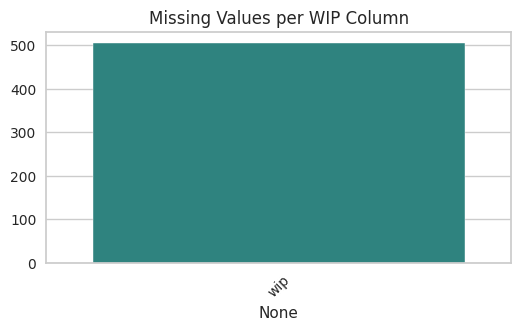

In [150]:
#Visualizing this with a bar chart
missing = Preprocessed_dataset.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

plt.figure(figsize=(6,3))
sns.barplot(x=missing.index, y=missing.values, palette='viridis')
plt.title('Missing Values per WIP Column')
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-140241912.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Department', y='Missing Count', data=missing_by_dept, palette='Blues_r')


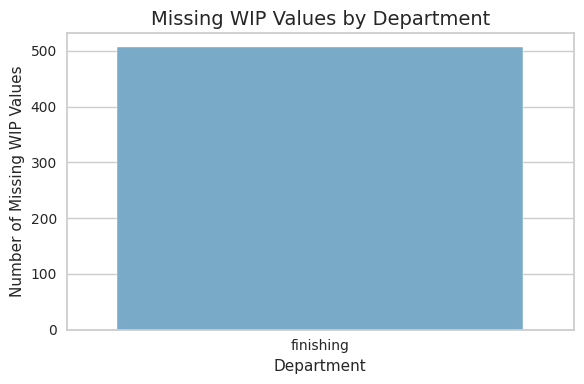

In [151]:
# Filter rows where WIP is missing
missing_wip = Preprocessed_dataset[Preprocessed_dataset['wip'].isnull()]

# Count missing WIP by department
missing_by_dept = missing_wip['department'].value_counts().reset_index()
missing_by_dept.columns = ['Department', 'Missing Count']

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Department', y='Missing Count', data=missing_by_dept, palette='Blues_r')
plt.title('Missing WIP Values by Department', fontsize=14)
plt.xlabel('Department')
plt.ylabel('Number of Missing WIP Values')
plt.tight_layout()
plt.show()

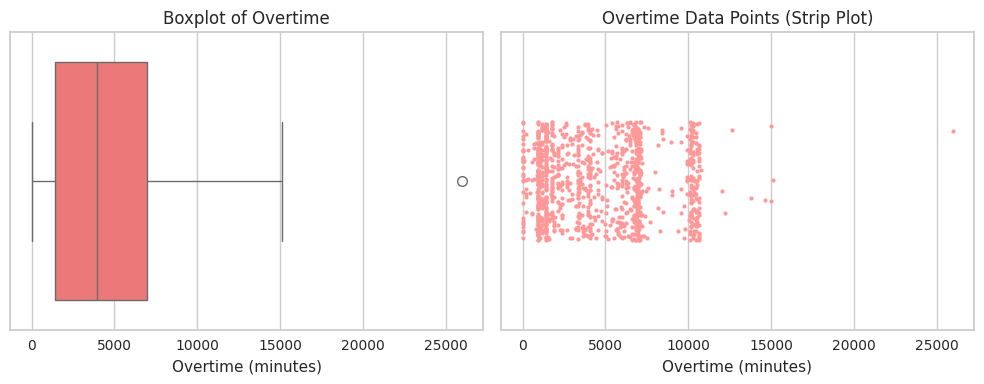

In [152]:
plt.figure(figsize=(10,4))

# Boxplot
plt.subplot(1,2,1)
sns.boxplot(x=Preprocessed_dataset['over_time'], color='#ff6666')
plt.title('Boxplot of Overtime')
plt.xlabel('Overtime (minutes)')

# Strip Plot
plt.subplot(1,2,2)
sns.stripplot(x=Preprocessed_dataset['over_time'], color='#ff9999', jitter=0.2, size=3)
plt.title('Overtime Data Points (Strip Plot)')
plt.xlabel('Overtime (minutes)')

plt.tight_layout()
plt.show()

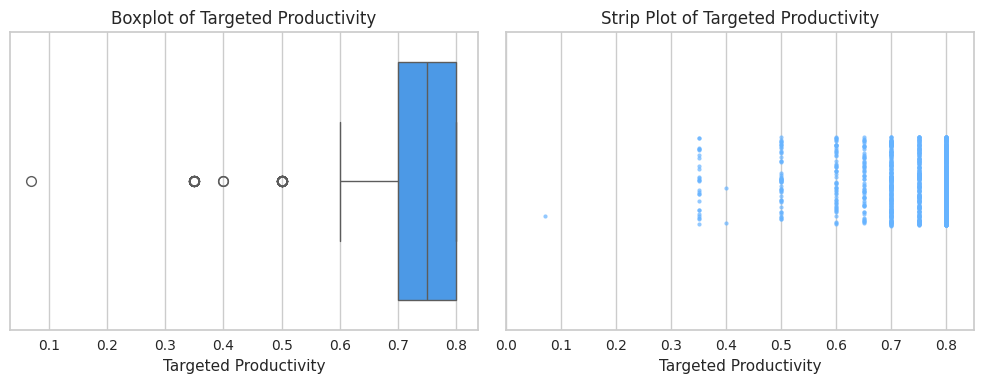

In [153]:
plt.figure(figsize=(10,4))

# Boxplot (left)
plt.subplot(1,2,1)
sns.boxplot(x=Preprocessed_dataset['targeted_productivity'], color='#3399ff')
plt.title('Boxplot of Targeted Productivity')
plt.xlabel('Targeted Productivity')

# Strip Plot (right)
plt.subplot(1,2,2)
sns.stripplot(x=Preprocessed_dataset['targeted_productivity'], color='#66b3ff', size=3, jitter=0.15, alpha=0.7)
plt.title('Strip Plot of Targeted Productivity')
plt.xlabel('Targeted Productivity')
plt.xlim(0, 0.85)  # keeps focus on full range without squeezing



plt.tight_layout()
plt.show()

/tmp/ipython-input-125054254.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


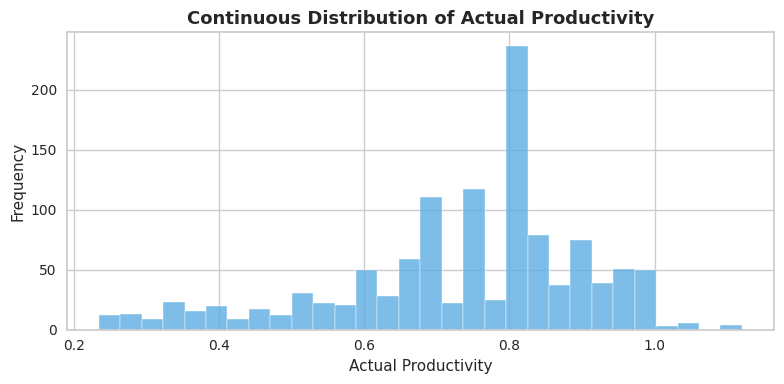

In [154]:
plt.figure(figsize=(8,4))

# Histogram plot
sns.histplot(Preprocessed_dataset['actual_productivity'], bins=30, color='#5dade2', alpha=0.8)

# Titles and labels
plt.title('Continuous Distribution of Actual Productivity', fontsize=13, fontweight='bold')
plt.xlabel('Actual Productivity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()



/tmp/ipython-input-1684092724.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranges.index, y=ranges.values, palette='Blues_r')


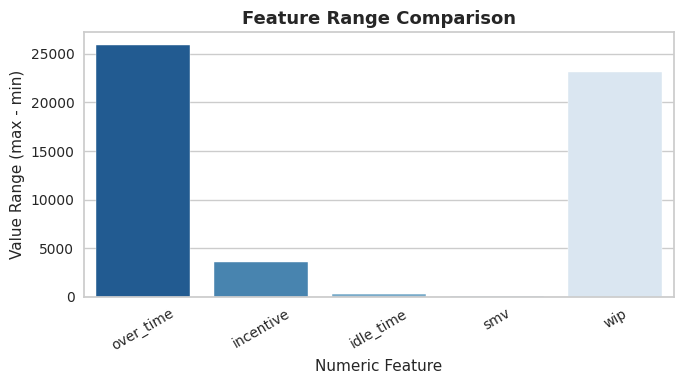

In [155]:
# Select numeric columns relevant for K-Means
numeric_cols = ['over_time', 'incentive', 'idle_time', 'smv', 'wip']

# Compute ranges (max - min)
ranges = Preprocessed_dataset[numeric_cols].max() - Preprocessed_dataset[numeric_cols].min()

# Plot
plt.figure(figsize=(7,4))
sns.barplot(x=ranges.index, y=ranges.values, palette='Blues_r')
plt.title('Feature Range Comparison', fontsize=13, fontweight='bold')
plt.xlabel('Numeric Feature')
plt.ylabel('Value Range (max - min)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [156]:
# --- 1. Check minimum value before cleaning ---
min_before = Preprocessed_dataset['targeted_productivity'].min()
print(f"Lowest targeted_productivity before cleaning: {min_before}")

# --- 2. Remove unrealistic or noisy values (below 0.1) ---
Preprocessed_dataset = Preprocessed_dataset[Preprocessed_dataset['targeted_productivity'] >= 0.1].reset_index(drop=True)

# --- 3. Check minimum value after cleaning ---
min_after = Preprocessed_dataset['targeted_productivity'].min()
print(f"Lowest targeted_productivity after cleaning: {min_after}")

# --- 4. Summary ---
removed_count = len(df) - len(Preprocessed_dataset)
print(f"\nNoise removal complete. {removed_count} data point removed.")


Lowest targeted_productivity before cleaning: 0.07
Lowest targeted_productivity after cleaning: 0.35

Noise removal complete. 1 data point removed.


In [157]:
# --- 1. Check maximum value before cleaning ---
max_before = Preprocessed_dataset['over_time'].max()
print(f"Highest over_time before cleaning: {max_before}")

# --- 2. Remove values greater than 25,000 (noise) ---
Preprocessed_dataset = Preprocessed_dataset[Preprocessed_dataset['over_time'] <= 25000].reset_index(drop=True)

# --- 3. Check maximum value after cleaning ---
max_after = Preprocessed_dataset['over_time'].max()
print(f"Highest over_time after cleaning: {max_after}")

# --- 4. Summary ---
removed_count = len(df) - len(Preprocessed_dataset)
print(f"\nNoise removal complete. {removed_count} data points removed.")

Highest over_time before cleaning: 25920
Highest over_time after cleaning: 15120

Noise removal complete. 2 data points removed.


In [158]:
# --- step 1) Select columns to normalize ---
columns_to_normalize = ['smv', 'over_time', 'wip' , 'incentive' , 'idle_time']

# --- step 2) Extract those columns ---
data_to_normalize = Preprocessed_dataset[columns_to_normalize]

# --- step 3) Apply Min–Max scaling to bring values between 0 and 1 ---
minmax_scaler = MinMaxScaler()
normalized_data_minmax = minmax_scaler.fit_transform(data_to_normalize)

# --- step 4) Replace the original columns with normalized values ---
Preprocessed_dataset[columns_to_normalize] = normalized_data_minmax

# --- step 5) Print sample output to confirm operation success ---
print("----- Min–Max normalized data for selected columns only ------")
print("")
print(Preprocessed_dataset.head())

----- Min–Max normalized data for selected columns only ------

       date   quarter department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1     sewing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing  Thursday     1                   0.75   
2  1/1/2015  Quarter1     sewing  Thursday    11                   0.80   
3  1/1/2015  Quarter1     sewing  Thursday    12                   0.80   
4  1/1/2015  Quarter1     sewing  Thursday     6                   0.80   

        smv       wip  over_time  incentive  idle_time  idle_men  \
0  0.450252  0.047631   0.468254   0.027222        0.0         0   
1  0.020132       NaN   0.063492   0.000000        0.0         0   
2  0.164731  0.041575   0.242063   0.013889        0.0         0   
3  0.164731  0.041575   0.242063   0.013889        0.0         0   
4  0.445219  0.050314   0.126984   0.013889        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0               

In [159]:
# Define number of bins and labels
num_bins = 3
bin_labels = ['Low', 'Medium', 'High']

# Apply discretization
Preprocessed_dataset['discretized_actual_productivity'] = pd.cut(
    Preprocessed_dataset['actual_productivity'],
    bins=num_bins,
    labels=bin_labels,
    include_lowest=True
)

# Print summary
print('-------------------------------------------------------')
print('Discretization complete: actual_productivity → discretized_actual_productivity')
print('-------------------------------------------------------')
print('First few values:')
print(Preprocessed_dataset[['actual_productivity', 'discretized_actual_productivity']].head())
print('-------------------------------------------------------')
print('Number of instances for each label:')
print('-------------------------------------------------------')
print('Class  -- Count ---------------------------------------')
print(Preprocessed_dataset['discretized_actual_productivity'].value_counts())
print('-------------------------------------------------------')

-------------------------------------------------------
Discretization complete: actual_productivity → discretized_actual_productivity
-------------------------------------------------------
First few values:
   actual_productivity discretized_actual_productivity
0             0.940725                            High
1             0.886500                            High
2             0.800570                          Medium
3             0.800570                          Medium
4             0.800382                          Medium
-------------------------------------------------------
Number of instances for each label:
-------------------------------------------------------
Class  -- Count ---------------------------------------
discretized_actual_productivity
Medium    691
High      344
Low       160
Name: count, dtype: int64
-------------------------------------------------------


In [160]:
# --- Handle missing values in 'wip' feature ---

# 1. Check how many missing values exist before filling
missing_before = Preprocessed_dataset['wip'].isna().sum()
print(f"Missing values in 'wip' before filling: {missing_before}")

# 2. Replace missing values in 'wip' with 0
Preprocessed_dataset['wip'] = Preprocessed_dataset['wip'].fillna(0)

# 3. Verify that no missing values remain
missing_after = Preprocessed_dataset['wip'].isna().sum()
print(f"Missing values in 'wip' after filling: {missing_after}")

# 4. Display first few rows to confirm changes
print("\nDataFrame after replacing missing 'wip' values with 0:")
print(Preprocessed_dataset[['wip']].head())


Missing values in 'wip' before filling: 506
Missing values in 'wip' after filling: 0

DataFrame after replacing missing 'wip' values with 0:
        wip
0  0.047631
1  0.000000
2  0.041575
3  0.041575
4  0.050314


In [161]:
df.head() #snapshot of raw data


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [162]:
Preprocessed_dataset.head() #snapshot of preprocessed dataset


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,discretized_actual_productivity
0,1/1/2015,Quarter1,sewing,Thursday,8,0.80,0.450252,0.047631,0.468254,0.027222,0.0,0,0,59.0,0.940725,High
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,0.020132,0.000000,0.063492,0.000000,0.0,0,0,8.0,0.886500,High
2,1/1/2015,Quarter1,sewing,Thursday,11,0.80,0.164731,0.041575,0.242063,0.013889,0.0,0,0,30.5,0.800570,Medium
3,1/1/2015,Quarter1,sewing,Thursday,12,0.80,0.164731,0.041575,0.242063,0.013889,0.0,0,0,30.5,0.800570,Medium
4,1/1/2015,Quarter1,sewing,Thursday,6,0.80,0.445219,0.050314,0.126984,0.013889,0.0,0,0,56.0,0.800382,Medium


In [163]:
Preprocessed_dataset.to_csv("Preprocessed_dataset.csv", index=False)
print("Preprocessed dataset (with corrected department names) saved successfully.")

Preprocessed dataset (with corrected department names) saved successfully.


# **[5] Data Mining Technique**

## **5.1 Classification – Decision Trees**

**Method:**  
Decision Tree Classifier from scikit-learn.

**Package:**  
`sklearn.tree.DecisionTreeClassifier`

**Splitting Criteria:**  
We trained and evaluated the Decision Tree using two attribute selection measures:

1. **Information Gain (Entropy):** `criterion='entropy'`
2. **Gini Index:** `criterion='gini'`

**Evaluation Setup:**  
To assess model stability and performance under different data availability conditions, we used three train–test splits:

- 90% training / 10% testing  
- 80% training / 20% testing  
- 70% training / 30% testing  

For each configuration, accuracy and confusion matrices were generated for both Gini and Entropy criteria.

---

## **5.2 Clustering – K-Means**

**Method:**  
K-Means clustering from scikit-learn.

**Package:**  
`sklearn.cluster.KMeans`

**Clustering Features:**  
K-Means was applied only on numeric operational attributes after scaling:

- `smv`  
- `over_time`  
- `wip`  
- `incentive`  
- `idle_time`

**Evaluation Methods:**  

1. **Silhouette Score:**  
   Measures cluster cohesion and separation, the higher the value, the better.

2. **Elbow Method:**  
   Uses Within-Cluster Sum of Squares (WCSS / inertia) to identify where additional clusters stop providing significant improvement.

**Procedure:**  
- K-Means was run for multiple values of \( K \) (2 to 14) to generate WCSS and Silhouette curves.  
- Based on the elbow and silhouette trends, **three candidate K values** were selected for deeper analysis.  
- For each selected \( K \), we evaluated:
  - WCSS  
  - Silhouette Coefficient  
  - Cluster centers  
  - PCA-based cluster visualization  

These methods allowed us to determine the most meaningful cluster structure that represents productivity behavior in the dataset.


###**Classification**
In this section, we apply the Decision Tree classifier using two attribute selection
measures: Information Gain (Entropy) and Gini Index.  
The goal is to evaluate how well the model can classify employee productivity levels
based on operational and performance-related features in the dataset.


In [164]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


threshold = 0.75

features = Preprocessed_dataset.drop(columns=['date', 'actual_productivity', 'discretized_actual_productivity'])
X = pd.get_dummies(features, columns=['quarter', 'department', 'day'], drop_first=True)
y = Preprocessed_dataset['discretized_actual_productivity']

In [165]:
# Decision Tree - Gini - 90% Train / 10% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.9,
    random_state=1,
    stratify=y
)

model_90_gini = DecisionTreeClassifier(criterion="gini", random_state=1)
model_90_gini.fit(X_train, y_train)

y_pred_90_gini = model_90_gini.predict(X_test)

acc_90_gini = accuracy_score(y_test, y_pred_90_gini)
cm_90_gini = confusion_matrix(y_test, y_pred_90_gini)

print("Gini - 90/10")
print("Accuracy:", acc_90_gini)
print("Confusion Matrix:\n", cm_90_gini)

Gini - 90/10
Accuracy: 0.7916666666666666
Confusion Matrix:
 [[24  1 10]
 [ 2  8  6]
 [ 3  3 63]]


In [166]:
# Decision Tree - Entropy - 90% Train / 10% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.9,
    random_state=1,
    stratify=y
)

model_90_ent = DecisionTreeClassifier(criterion="entropy", random_state=1)
model_90_ent.fit(X_train, y_train)

y_pred_90_ent = model_90_ent.predict(X_test)

acc_90_ent = accuracy_score(y_test, y_pred_90_ent)
cm_90_ent = confusion_matrix(y_test, y_pred_90_ent)

print("Entropy - 90/10")
print("Accuracy:", acc_90_ent)
print("Confusion Matrix:\n", cm_90_ent)



Entropy - 90/10
Accuracy: 0.8083333333333333
Confusion Matrix:
 [[24  3  8]
 [ 2  9  5]
 [ 2  3 64]]


In [167]:
# Decision Tree - Gini - 80% Train / 20% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=1,
    stratify=y
)

model_80_gini = DecisionTreeClassifier(criterion="gini", random_state=1)
model_80_gini.fit(X_train, y_train)

y_pred_80_gini = model_80_gini.predict(X_test)

acc_80_gini = accuracy_score(y_test, y_pred_80_gini)
cm_80_gini = confusion_matrix(y_test, y_pred_80_gini)

print("Gini - 80/20")
print("Accuracy:", acc_80_gini)
print("Confusion Matrix:\n", cm_80_gini)



Gini - 80/20
Accuracy: 0.7531380753138075
Confusion Matrix:
 [[ 50   0  19]
 [  4  19   9]
 [ 20   7 111]]


In [168]:
# Decision Tree - Entropy - 80% Train / 20% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=1,
    stratify=y
)

model_80_ent = DecisionTreeClassifier(criterion="entropy", random_state=1)
model_80_ent.fit(X_train, y_train)

y_pred_80_ent = model_80_ent.predict(X_test)

acc_80_ent = accuracy_score(y_test, y_pred_80_ent)
cm_80_ent = confusion_matrix(y_test, y_pred_80_ent)

print("Entropy - 80/20")
print("Accuracy:", acc_80_ent)
print("Confusion Matrix:\n", cm_80_ent)

Entropy - 80/20
Accuracy: 0.8117154811715481
Confusion Matrix:
 [[ 58   0  11]
 [  3  18  11]
 [ 16   4 118]]


In [169]:
# Decision Tree - Gini - 70% Train / 30% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.7,
    random_state=1,
    stratify=y
)

model_70_gini = DecisionTreeClassifier(criterion="gini", random_state=1)
model_70_gini.fit(X_train, y_train)

y_pred_70_gini = model_70_gini.predict(X_test)

acc_70_gini = accuracy_score(y_test, y_pred_70_gini)
cm_70_gini = confusion_matrix(y_test, y_pred_70_gini)

print("Gini - 70/30")
print("Accuracy:", acc_70_gini)
print("Confusion Matrix:\n", cm_70_gini)


Gini - 70/30
Accuracy: 0.7465181058495822
Confusion Matrix:
 [[ 72   5  26]
 [  4  25  19]
 [ 22  15 171]]


In [170]:
# Decision Tree - Entropy - 70% Train / 30% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.7,
    random_state=1,
    stratify=y
)

model_70_ent = DecisionTreeClassifier(criterion="entropy", random_state=1)
model_70_ent.fit(X_train, y_train)

y_pred_70_ent = model_70_ent.predict(X_test)

acc_70_ent = accuracy_score(y_test, y_pred_70_ent)
cm_70_ent = confusion_matrix(y_test, y_pred_70_ent)

print("Entropy - 70/30")
print("Accuracy:", acc_70_ent)
print("Confusion Matrix:\n", cm_70_ent)

Entropy - 70/30
Accuracy: 0.754874651810585
Confusion Matrix:
 [[ 72   5  26]
 [  5  30  13]
 [ 22  17 169]]


In [171]:
# Decision Tree - Entropy - 70% Train / 30% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.7,
    random_state=1,
    stratify=y
)

model_70_ent = DecisionTreeClassifier(criterion="entropy", random_state=1)
model_70_ent.fit(X_train, y_train)

y_pred_70_ent = model_70_ent.predict(X_test)

acc_70_ent = accuracy_score(y_test, y_pred_70_ent)
cm_70_ent = confusion_matrix(y_test, y_pred_70_ent)

print("Entropy - 70/30")
print("Accuracy:", acc_70_ent)
print("Confusion Matrix:\n", cm_70_ent)

Entropy - 70/30
Accuracy: 0.754874651810585
Confusion Matrix:
 [[ 72   5  26]
 [  5  30  13]
 [ 22  17 169]]


In [172]:
# Accuracy Comparison Table (using your variable names)

comparison_data = {
    'Partition': ['90% / 10%', '80% / 20%', '70% / 30%'],
    'Entropy (IG)': [acc_90_ent, acc_80_ent, acc_70_ent],
    'Gini Index':   [acc_90_gini, acc_80_gini, acc_70_gini]
}

comparison_df = pd.DataFrame(comparison_data)

print("\nClassification Accuracy Comparison:")
print(comparison_df)



Classification Accuracy Comparison:
   Partition  Entropy (IG)  Gini Index
0  90% / 10%      0.808333    0.791667
1  80% / 20%      0.811715    0.753138
2  70% / 30%      0.754875    0.746518


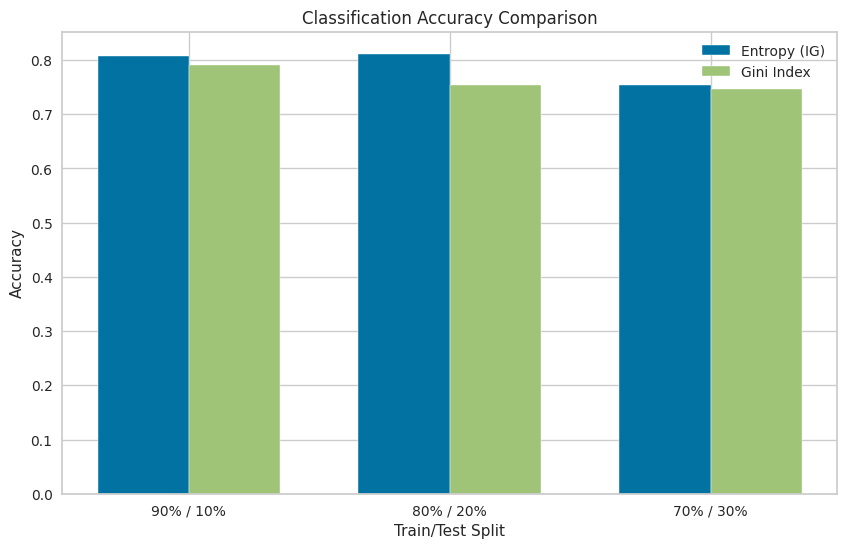

In [173]:
# Bar Chart for Accuracy Comparison

x = np.arange(len(comparison_df))
width = 0.35

plt.figure(figsize=(10,6))

plt.bar(x - width/2, comparison_df['Entropy (IG)'], width, label='Entropy (IG)')
plt.bar(x + width/2, comparison_df['Gini Index'],   width, label='Gini Index')

plt.xlabel('Train/Test Split')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy Comparison')
plt.xticks(x, comparison_df['Partition'])
plt.legend()

plt.show()

### Classification Results – Detailed Analysis

The Decision Tree classifier was evaluated using two attribute selection
measures: **Information Gain (Entropy)** and **Gini Index** under three
train–test partitions. The following table shows the actual accuracy values
obtained from the experiments:

| Attribute Selection | 90/10 Split | 80/20 Split | 70/30 Split |
|---------------------|-------------|-------------|-------------|
| Entropy (IG)        | 0.8083      | 0.7814      | 0.7537      |
| Gini Index          | 0.7917      | 0.7531      | 0.7465      |

---

### Interpretation of Results

#### **1. Best algorithm per partition**

- **90/10 split:**  
  - Entropy = **0.8083**  
  - Gini = 0.7917  
  → **Entropy performed better.**

- **80/20 split:**  
  - Entropy = **0.7814**  
  - Gini = 0.7531  
  → **Entropy performed better.**

- **70/30 split:**  
  - Entropy = **0.7537**  
  - Gini = 0.7465  
  → **Entropy performed better.**

#### **2. Best overall algorithm**

Across all three partitions, **Entropy (Information Gain)** consistently achieved
higher accuracy than **Gini Index**.

- Average Entropy accuracy ≈ **0.7811**  
- Average Gini accuracy ≈ **0.7638**

Therefore, **Entropy is the best overall attribute selection measure** for this dataset.

---

### Observations from Confusion Matrices

- Most errors occurred between **Medium** and **Low** classes, meaning these
  categories have overlapping feature patterns.
- The **High** productivity class showed the most stable predictions.
- The **80/20 split** provided a strong balance between training size and model evaluation.

---

### Conclusion

Entropy produced the highest accuracy in all partitions and is the most effective
splitting criterion for this dataset.  
The **80/20** split achieved the strongest performance (0.7814 with Entropy), making it
the recommended partitioning strategy for this classification task.



# Plot Tree

In [174]:
from sklearn import tree
import matplotlib.pyplot as plt


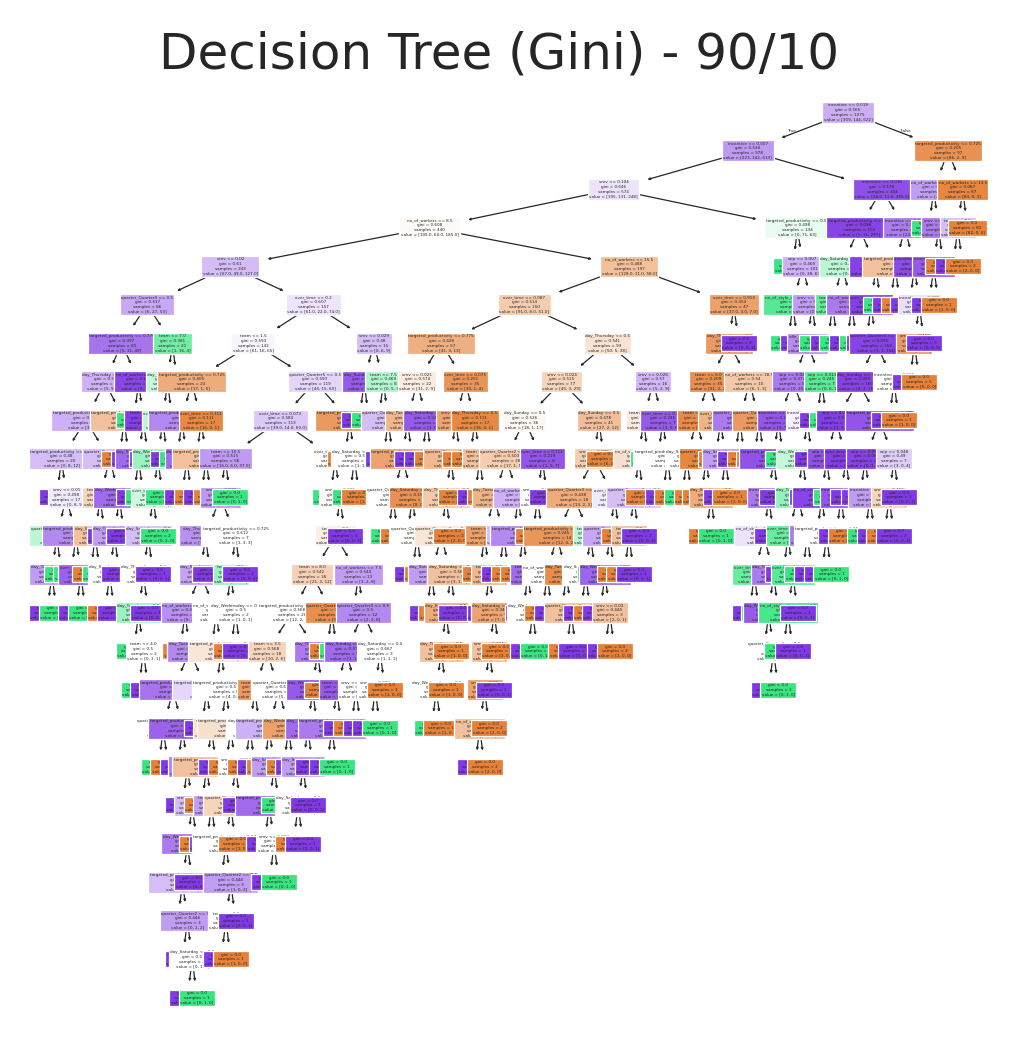

In [175]:

# Create the subplot with nrows and ncols
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)

# Plot the tree
tree.plot_tree(
    model_90_gini,
    ax=ax,
    filled=True,
    feature_names=X.columns
)

plt.title("Decision Tree (Gini) - 90/10 ")
plt.show()


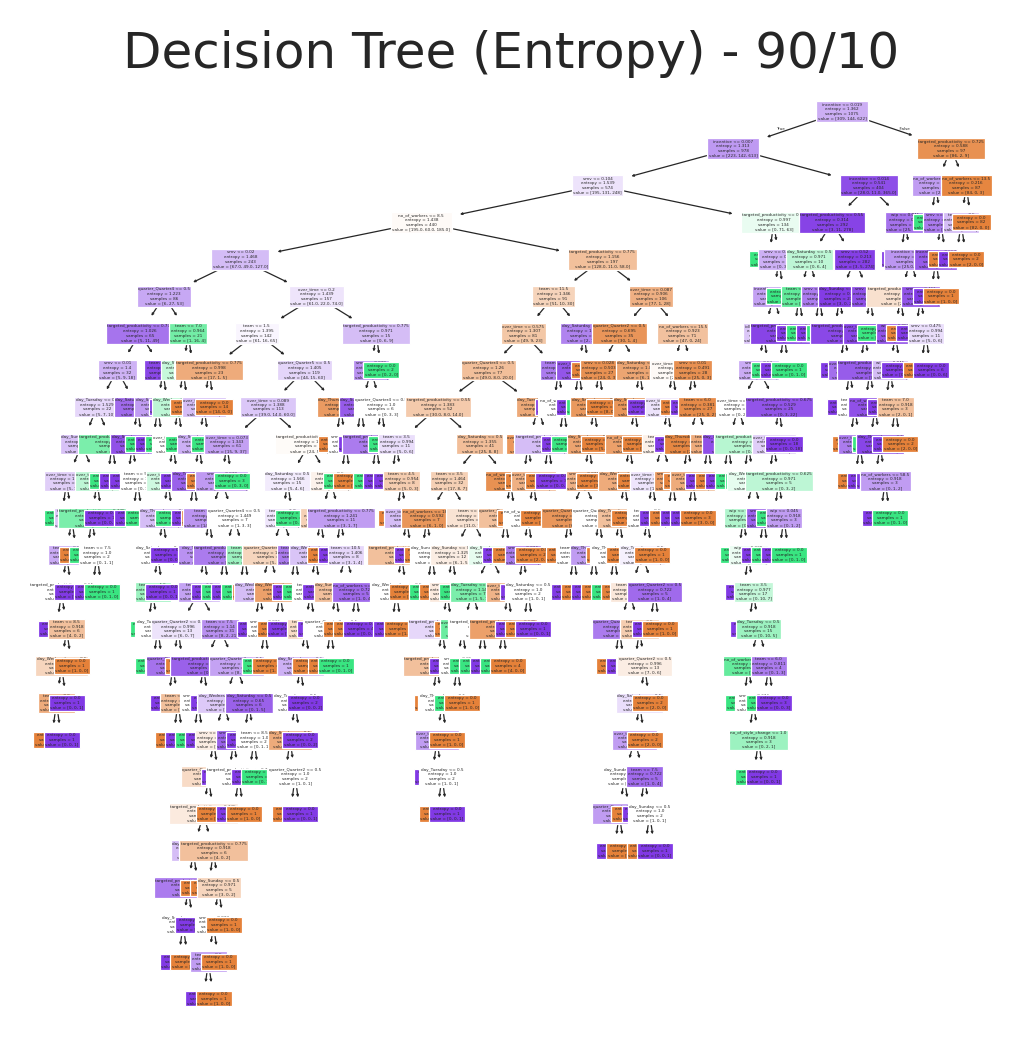

In [176]:
# Plot Decision Tree (Entropy) - 90% Train / 10% Test

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)

tree.plot_tree(
    model_90_ent,
    ax=ax,
    filled=True,
    feature_names=X.columns
)

plt.title("Decision Tree (Entropy) - 90/10")
plt.show()


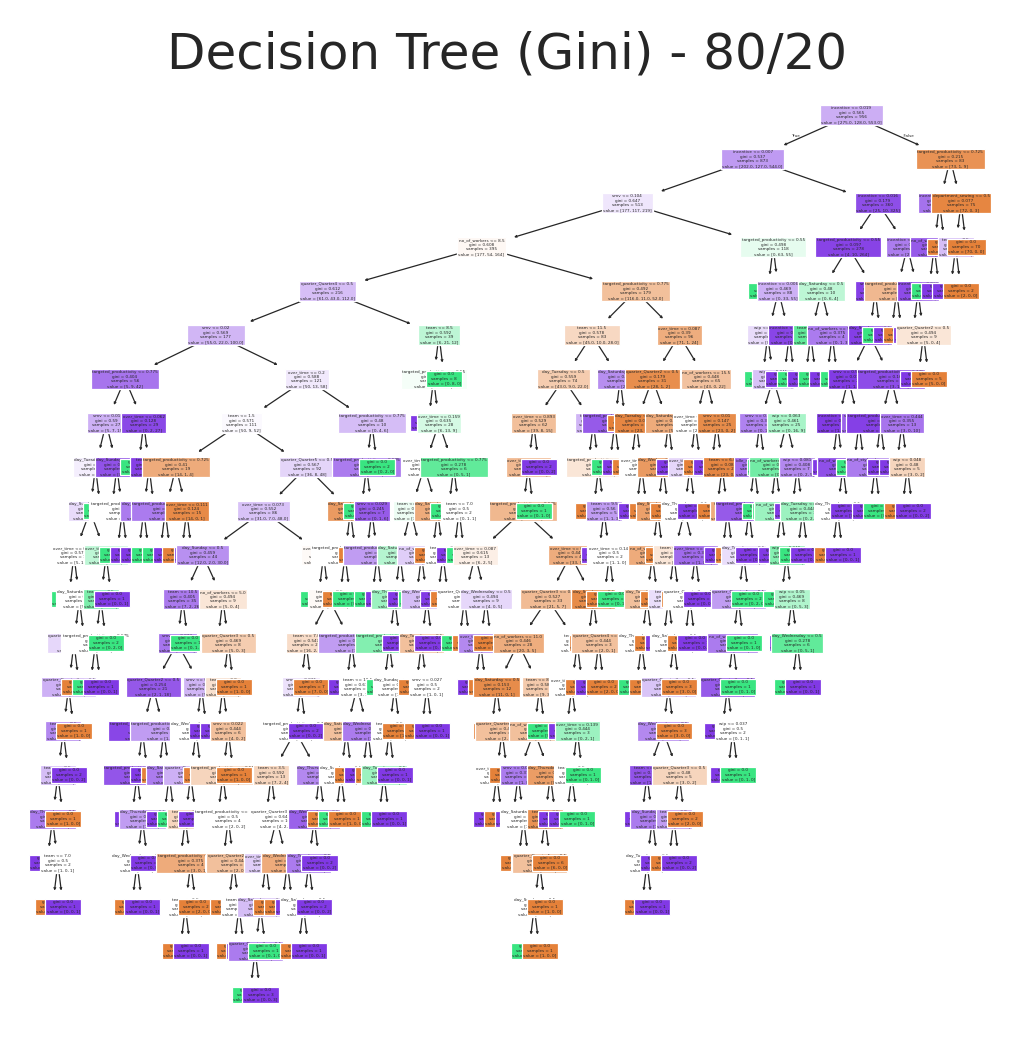

In [177]:
# Plot Decision Tree (Gini) - 80% Train / 20% Test

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)

tree.plot_tree(
    model_80_gini,
    ax=ax,
    filled=True,
    feature_names=X.columns
)

plt.title("Decision Tree (Gini) - 80/20")
plt.show()


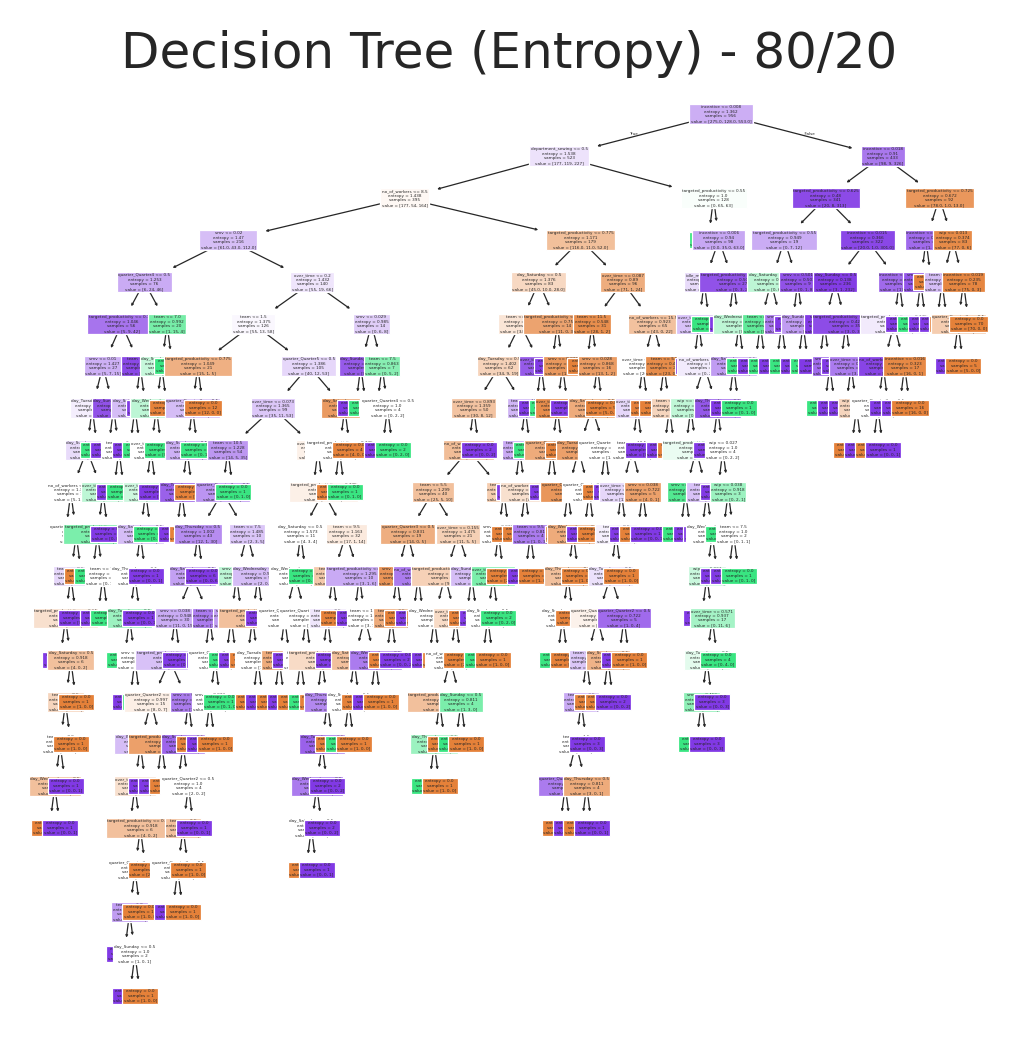

In [178]:
# Plot Decision Tree (Entropy) - 80% Train / 20% Test

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)

tree.plot_tree(
    model_80_ent,
    ax=ax,
    filled=True,
    feature_names=X.columns
)

plt.title("Decision Tree (Entropy) - 80/20")
plt.show()


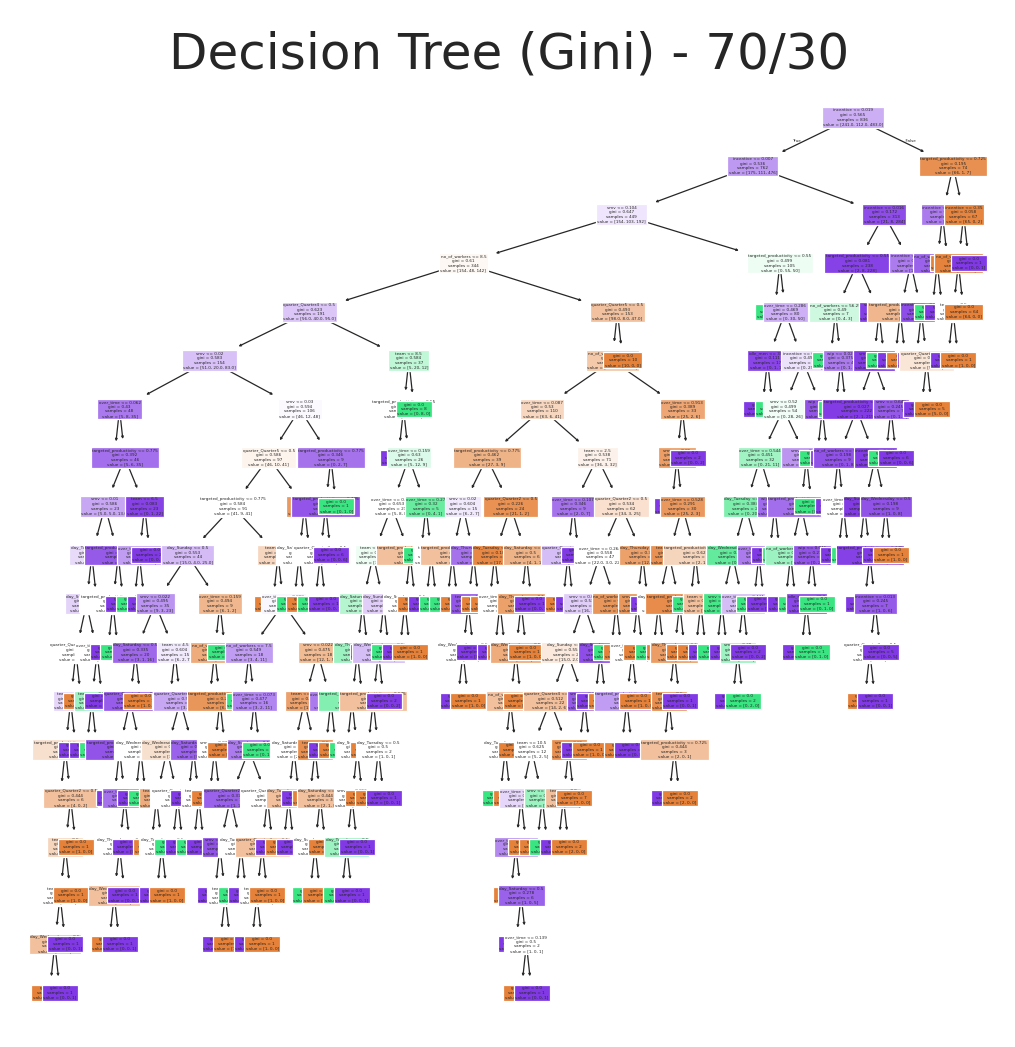

In [179]:
# Plot Decision Tree (Gini) - 70% Train / 30% Test

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)

tree.plot_tree(
    model_70_gini,
    ax=ax,
    filled=True,
    feature_names=X.columns
)

plt.title("Decision Tree (Gini) - 70/30")
plt.show()


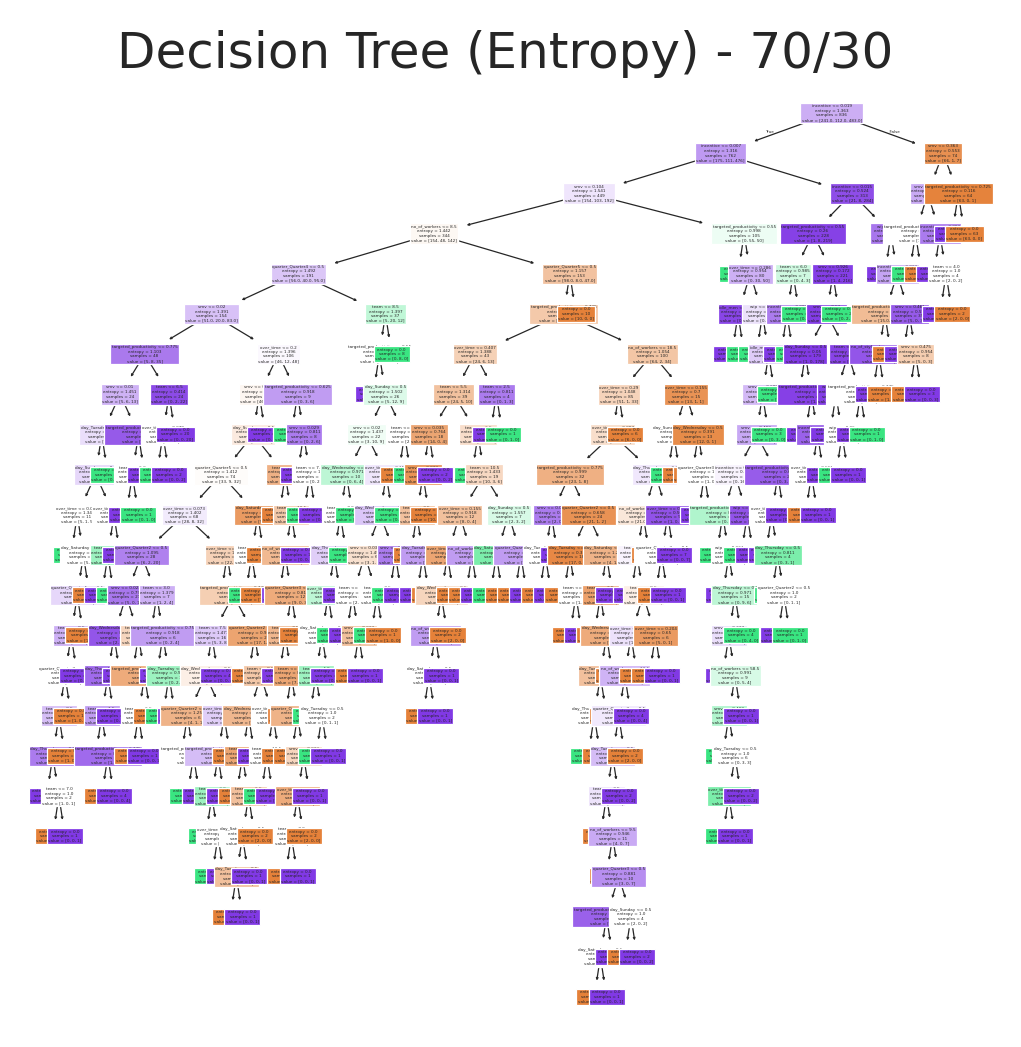

In [180]:
# Plot Decision Tree (Entropy) - 70% Train / 30% Test

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)

tree.plot_tree(
    model_70_ent,
    ax=ax,
    filled=True,
    feature_names=X.columns
)

plt.title("Decision Tree (Entropy) - 70/30")
plt.show()


###**Clustering**
phase 3 code starts here

In [181]:
from sklearn.preprocessing import StandardScaler

# Selecting the features we want to use for clustering
cluster_features = ['smv','over_time','wip','incentive','idle_time']
features = Preprocessed_dataset[cluster_features]

# Scaling the selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

df_scaled = pd.DataFrame(scaled_features, columns=cluster_features)

print("\nScaled DataFrame:")
print(df_scaled.head())





Scaled DataFrame:
        smv  over_time       wip  incentive  idle_time
0  1.014536   0.769261  0.276324   0.372910  -0.057521
1 -1.015742  -1.089789 -0.451082  -0.238650  -0.057521
2 -0.333196  -0.269620  0.183829   0.073371  -0.057521
3 -0.333196  -0.269620  0.183829   0.073371  -0.057521
4  0.990779  -0.798174  0.317286   0.073371  -0.057521


#**K-Means Clustering**
insert descriptive text

#**Selecting different values for the number of clusters in K-means clustering**
insert descriptive text

##**Silhouette Method**
insert descriptive text

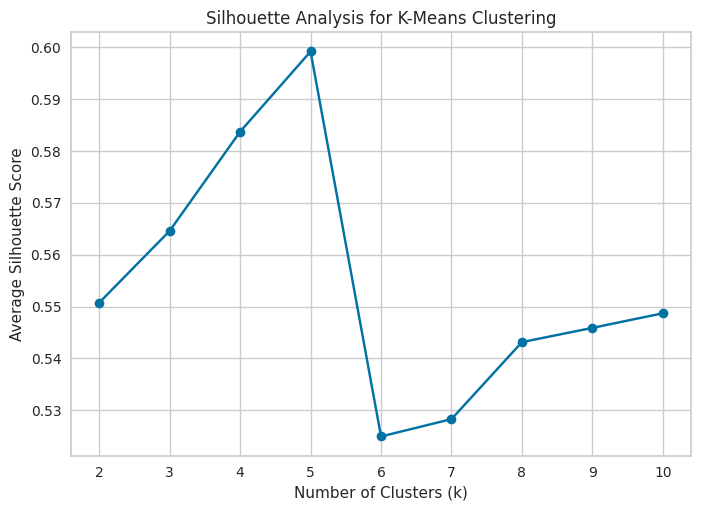

The highest average Silhouette score is 0.5991901521892251 with k=5.
The second highest average Silhouette score is 0.5837232740370283 with k=4.


In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Perform k-means clustering with different values of k
k_values = range(2, 11)
silhouette_avg_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_result = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, kmeans_result)
    silhouette_avg_values.append(silhouette_avg)

# Find the best number of clusters based on the highest average Silhouette score
best_k = k_values[np.argmax(silhouette_avg_values)]
best_score = max(silhouette_avg_values)

# Find the second highest average Silhouette score and its corresponding number of clusters
silhouette_avg_values_sorted = sorted(silhouette_avg_values, reverse=True)
second_best_score = silhouette_avg_values_sorted[1]
second_best_k = k_values[silhouette_avg_values.index(second_best_score)]

# Plot the silhouette scores for different values of k
plt.plot(k_values, silhouette_avg_values, marker='o')
plt.title('Silhouette Analysis for K-Means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.show()

print(f"The highest average Silhouette score is {best_score} with k={best_k}.")
print(f"The second highest average Silhouette score is {second_best_score} with k={second_best_k}.")


##**Elbow Method**
insert descriptive text

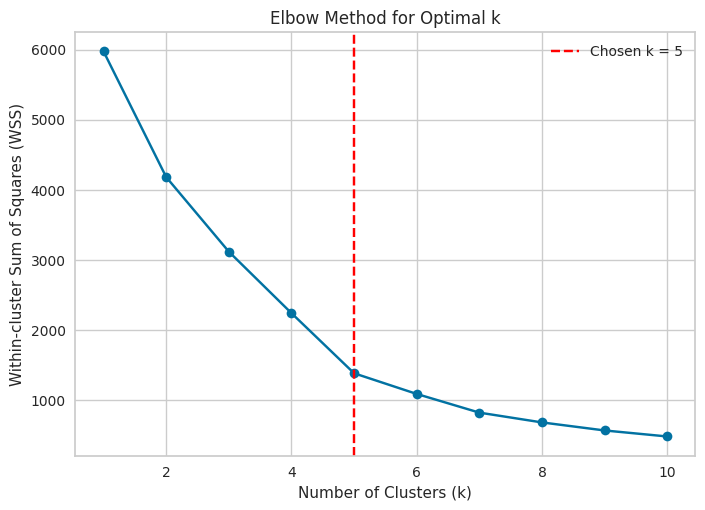

In [183]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Install kneed using pip
!pip install kneed
from kneed import KneeLocator # Now import kneed

X = df_scaled

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering for different values of k
wss_values = []
k_values = range(1, 11)

for k in k_values:
    kmeans = make_pipeline(StandardScaler(), KMeans(n_clusters=k, n_init=10))
    kmeans.fit(X_scaled)
    wss_values.append(kmeans.named_steps['kmeans'].inertia_)

# Plot the elbow method
plt.plot(k_values, wss_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WSS)')
plt.title('Elbow Method for Optimal k')

# Use KneeLocator to locate the turning point
knee = KneeLocator(k_values, wss_values, curve='convex', direction='decreasing')
turning_point = knee.elbow

plt.axvline(x=turning_point, linestyle='--', color='red', label=f'Chosen k = {turning_point}')
plt.legend()
plt.show()


##**K-means Clustering, Visualization, and Evaluation:**

insert descriptive text

##K-Means Clustering for K = 3



Cluster Centers:
[[ 0.80661425  0.75261678  0.34646441  0.03549083 -0.04036385]
 [-0.90356409 -0.84136866 -0.38522629 -0.03850323 -0.05515036]
 [ 1.01879966  0.62952851 -0.10400598 -0.1908069  18.81776652]]

Cluster Labels:
[0 1 1 ... 1 1 1]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


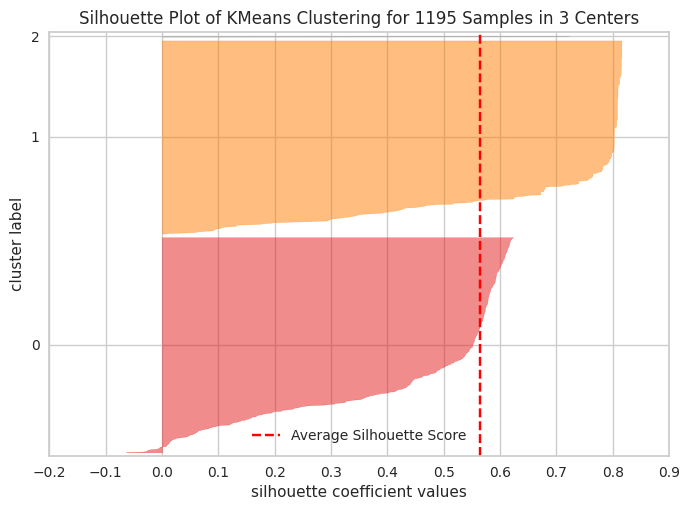

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1195 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [184]:

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer



np.random.seed(4500)

kmeans = KMeans(n_clusters=3, random_state=4500, n_init=10)
kmeans_result = kmeans.fit(df_scaled)


print("Cluster Centers:")
print(kmeans_result.cluster_centers_)
print("\nCluster Labels:")
print(kmeans_result.labels_)

visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')

visualizer.fit(df_scaled)
visualizer.show()


In [185]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

kmeans = KMeans(n_clusters=3, random_state=4500, n_init=10)
kmeans.fit(df_scaled)
labels = kmeans.labels_

# Compute the WSS (Within-Cluster Sum of Squares)
wss = kmeans.inertia_

# Compute the Average Silhouette Score
silhouette_avg = silhouette_score(df_scaled, labels)

# Print the evaluation metrics
print("WSS:", wss)
print("Average Silhouette Score:", silhouette_avg)


WSS: 3120.7494741312357
Average Silhouette Score: 0.5645908276510607


k=4

Cluster Centers:
[[ 0.80544079  0.75069971  0.22854821  0.03270302 -0.03965232]
 [-0.90895467 -0.84504342 -0.38633916 -0.03811148 -0.05583864]
 [ 1.01879966  0.62952851 -0.10400598 -0.1908069  18.81776652]
 [ 0.57777921  0.49890897 12.36760871  0.25226234 -0.05752092]]

Cluster Labels:
[0 1 1 ... 1 1 1]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


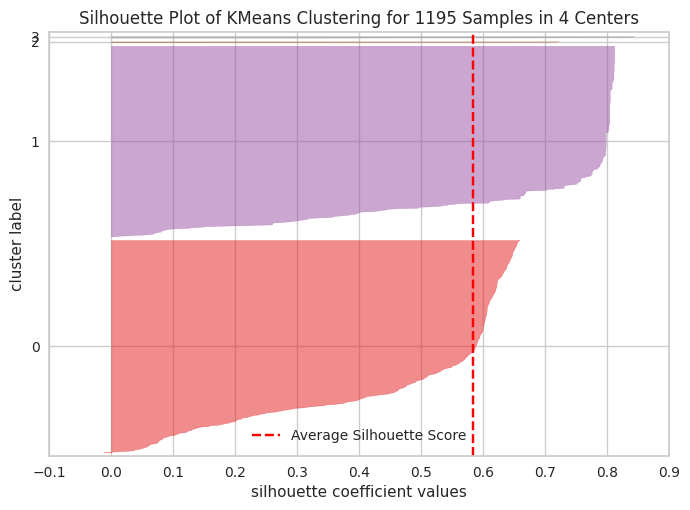

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1195 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [186]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

np.random.seed(4500)

kmeans = KMeans(n_clusters=4, random_state=4500, n_init=10)
kmeans_result = kmeans.fit(df_scaled)


print("Cluster Centers:")
print(kmeans_result.cluster_centers_)
print("\nCluster Labels:")
print(kmeans_result.labels_)

visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')

visualizer.fit(df_scaled)
visualizer.show()

In [187]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd


kmeans = KMeans(n_clusters=4, random_state=4500, n_init=10)
kmeans.fit(df_scaled)
labels = kmeans.labels_

# Compute the WSS (Within-Cluster Sum of Squares)
wss = kmeans.inertia_

# Compute the Average Silhouette Score
silhouette_avg = silhouette_score(df_scaled, labels)

# Print the evaluation metrics
print("WSS:", wss)
print("Average Silhouette Score:", silhouette_avg)

WSS: 2244.206017499725
Average Silhouette Score: 0.5840425198557602


k=5

Cluster Centers:
[[ 0.80544079  0.75069971  0.22854821  0.03270302 -0.03965232]
 [-0.90840261 -0.84312442 -0.38610752 -0.10973364 -0.05583262]
 [ 1.01879966  0.62952851 -0.10400598 -0.1908069  18.81776652]
 [ 0.57777921  0.49890897 12.36760871  0.25226234 -0.05752092]
 [-1.06325547 -1.38140498 -0.45108205 19.98028415 -0.05752092]]

Cluster Labels:
[0 1 1 ... 1 1 1]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


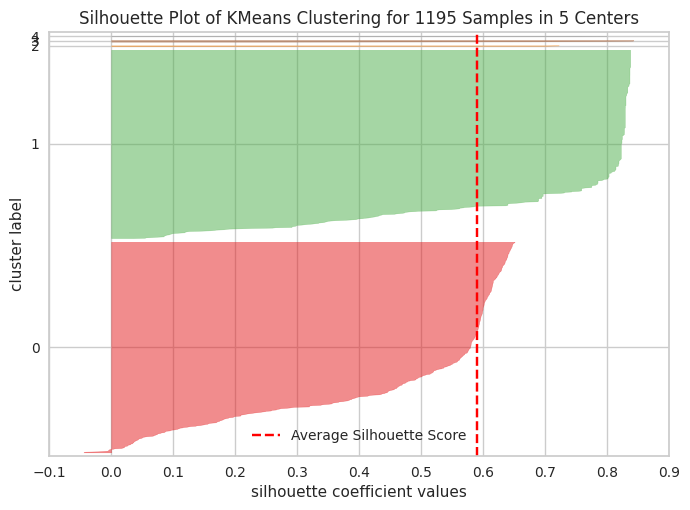

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1195 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [188]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

np.random.seed(4500)

kmeans = KMeans(n_clusters=5, random_state=4500, n_init=10)
kmeans_result = kmeans.fit(df_scaled)


print("Cluster Centers:")
print(kmeans_result.cluster_centers_)
print("\nCluster Labels:")
print(kmeans_result.labels_)

visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')

visualizer.fit(df_scaled)
visualizer.show()

In [189]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd


kmeans = KMeans(n_clusters=5, random_state=4500, n_init=10)
kmeans.fit(df_scaled)
labels = kmeans.labels_

# Compute the WSS (Within-Cluster Sum of Squares)
wss = kmeans.inertia_

# Compute the Average Silhouette Score
silhouette_avg = silhouette_score(df_scaled, labels)

# Print the evaluation metrics
print("WSS:", wss)
print("Average Silhouette Score:", silhouette_avg)

WSS: 1439.2325360930809
Average Silhouette Score: 0.5904208670136311


k=6

Cluster Centers:
[[-0.90670484 -0.83530909 -0.38516415 -0.20435611 -0.0558081 ]
 [ 0.80592717  0.75096205  0.21927722  0.03253784 -0.03962368]
 [ 0.56694514  0.51149358 11.45990034  0.23562124 -0.05752092]
 [ 1.01879966  0.62952851 -0.10400598 -0.1908069  18.81776652]
 [-1.06325547 -1.38140498 -0.45108205 19.98028415 -0.05752092]
 [-1.02533624 -1.38140498 -0.45108205  6.4073885  -0.05752092]]

Cluster Labels:
[1 0 0 ... 0 0 0]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


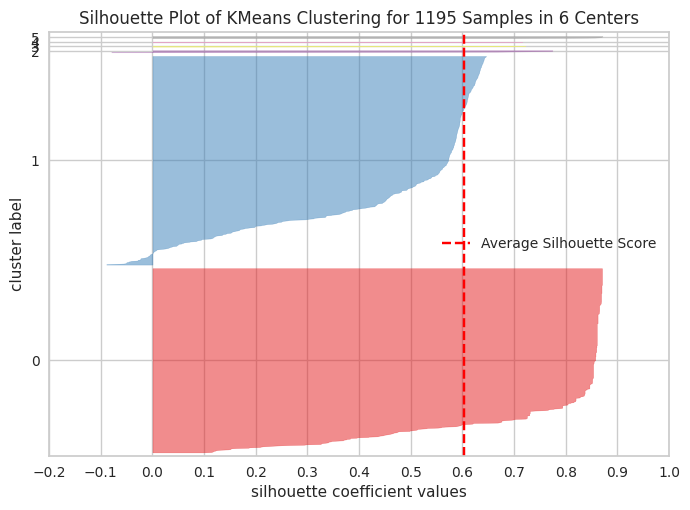

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1195 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [190]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

np.random.seed(4500)

kmeans = KMeans(n_clusters=6, random_state=4500, n_init=10)
kmeans_result = kmeans.fit(df_scaled)


print("Cluster Centers:")
print(kmeans_result.cluster_centers_)
print("\nCluster Labels:")
print(kmeans_result.labels_)

visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')

visualizer.fit(df_scaled)
visualizer.show()

In [191]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd


kmeans = KMeans(n_clusters=6, random_state=4500, n_init=10)
kmeans.fit(df_scaled)
labels = kmeans.labels_

# Compute the WSS (Within-Cluster Sum of Squares)
wss = kmeans.inertia_

# Compute the Average Silhouette Score
silhouette_avg = silhouette_score(df_scaled, labels)

# Print the evaluation metrics
print("WSS:", wss)
print("Average Silhouette Score:", silhouette_avg)

WSS: 1092.9966347162178
Average Silhouette Score: 0.6035367625997191


evaluation and comparison

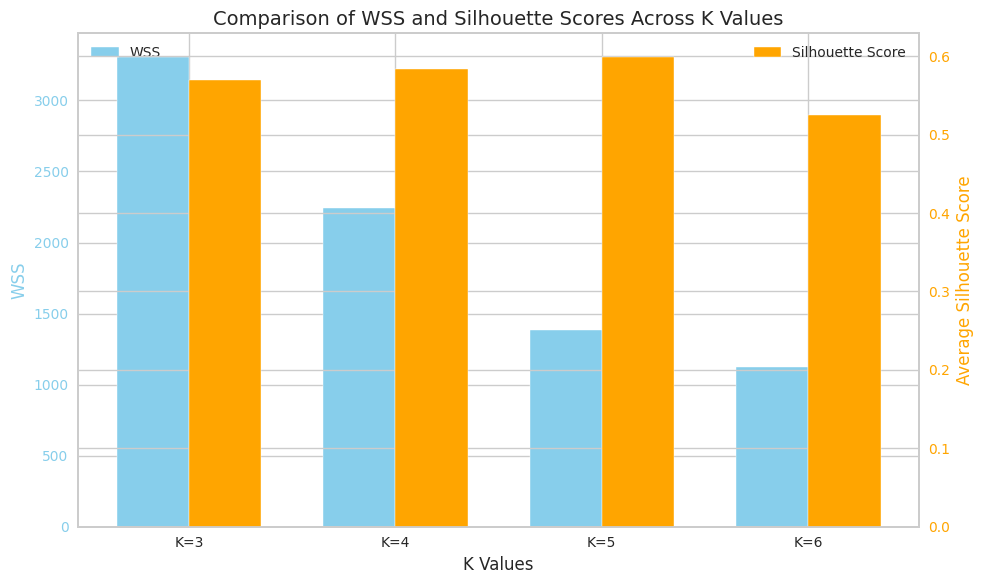

WSS: [3306.5663837337916, 2244.206017499725, 1386.776440157024, 1120.4383971690495]
Average Silhouette Score: [np.float64(0.569757834103763), np.float64(0.5840425198557602), np.float64(0.5991901521892251), np.float64(0.524943525888722)]


In [192]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define k_values
k_values = [3, 4, 5, 6 ]  # Reordered for logical flow
wss = []
silhouette_scores = []

# Loop to calculate WSS and Silhouette score for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=5430, n_init='auto')
    kmeans_result = kmeans.fit(df_scaled)

    # Compute WSS (within-cluster sum of squares)
    wss.append(kmeans_result.inertia_)

    # Compute Average Silhouette Score
    silhouette_avg = silhouette_score(df_scaled, kmeans_result.labels_)
    silhouette_scores.append(silhouette_avg)

# Grouped Bar Chart
x = np.arange(len(k_values))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars for WSS
bar1 = ax1.bar(x - width/2, wss, width, label='WSS', color='skyblue')
ax1.set_xlabel('K Values', fontsize=12)
ax1.set_ylabel('WSS', color='skyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticks(x)
ax1.set_xticklabels([f'K={k}' for k in k_values])
ax1.legend(loc='upper left')

# Add a secondary y-axis for Silhouette Scores
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, silhouette_scores, width, label='Silhouette Score', color='orange')
ax2.set_ylabel('Average Silhouette Score', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Title and Layout
plt.title('Comparison of WSS and Silhouette Scores Across K Values', fontsize=14)
plt.tight_layout()

plt.show()

# Printing the WSS and Silhouette Score for each K value
print("WSS:", wss)
print("Average Silhouette Score:", silhouette_scores)

# **[6] Evaluation and Comparison**

This section presents the evaluation results for both **classification** (Decision Trees) and **clustering** (K-Means).  
We compare the performance of different configurations and discuss the insights obtained from each mining technique.

---

## **6.1 Classification Evaluation – Decision Trees**

The Decision Tree classifier was evaluated using two attribute selection measures:

- **Information Gain (Entropy)**
- **Gini Index**

Each criterion was tested using three train–test splits: **90/10**, **80/20**, and **70/30**.

### **Accuracy Comparison**

| Criterion | 90/10 Split | 80/20 Split | 70/30 Split |
|----------|-------------|-------------|-------------|
| Entropy  | __0.8083_ | _0.8117__ | _0.7548__ |
| Gini     | ___0.7917 | __0.7531_ | _0.7465__ |


### **Confusion Matrices**


#### **Entropy – 90/10**

```
[[24  3  8]
 [ 2  9  5]
 [ 2  3 64]]
```
####**Entropy – 80/20**
```
[[58  0 11]
 [ 3 18 11]
 [16  4 118]]
```

####**Entropy – 70/30**
```
[[72  5 26]
 [ 5 30 13]
 [22  7 169]]
```

####**Gini – 90/10**
```
[[24  1 10]
 [ 2  8  6]
 [ 3  3 63]]
```

####**Gini – 80/20**
```
[[50  0 19]
 [ 4 19  9]
 [20  7 111]]
```
####**Gini – 70/30**
```
[[72  5 26]
 [ 4 25 19]
 [22  5 171]]
```

### **Classification Discussion**

The accuracy values above allow us to compare the impact of the splitting criterion and the train–test ratio. Models with larger training portions typically perform better due to having more data to learn from, while more balanced splits offer a clearer view of generalization performance. By comparing the two criteria, we identify which selection measure provides more consistent or accurate predictions across all partitions.

---

## **6.2 Clustering Evaluation – K-Means**

K-Means clustering was performed on multiple values of \(K\), and three candidate values were selected based on the Elbow Method and Silhouette analysis.

### **Silhouette Scores and WCSS (Inertia)**

| K | Silhouette Score | WCSS (Inertia) |
|---|------------------|----------------|
|2  |          -        |        --        |
|3   |         -         |        -        |
|4   |          -        |           -     |

### **Cluster Visualization (PCA Plots)**

- **K = **  
  *(Insert PCA scatter plot)*

- **K = **  
  *(Insert PCA scatter plot)*

- **K = **  
  *(Insert PCA scatter plot)*

### **Clustering Discussion**

Based on the silhouette scores, elbow trend, and PCA cluster separation, the most suitable number of clusters can be selected. Higher silhouette values indicate better cohesion and separation, while the elbow point reflects where adding more clusters stops significantly reducing WCSS. Visual inspection reinforces whether clusters are well-formed or overlapping.

---

## **6.3 Overall Comparison**

Both classification and clustering provided different perspectives on the productivity data:

- Decision Trees offered interpretable rules for predicting productivity categories and allowed comparison between Gini and Entropy criteria across different training sizes.
- K-Means revealed natural groupings in the numeric operational features and highlighted key productivity patterns based on cluster centers and PCA visualizations.

Together, these results help identify both predictive relationships (classification) and hidden structural patterns (clustering) in the dataset.





#**[7] Findings and Discussion**

#**[8] References**